# 第8章 音频扩散模型

## 8.1 实战：音频扩散模型

In [1]:
import torch, random
import numpy as np
import torch.nn.functional as F
from tqdm.auto import tqdm
from IPython.display import Audio
from matplotlib import pyplot as plt
from diffusers import DiffusionPipeline
from torchaudio import transforms as AT
from torchvision import transforms as IT

device = "cuda" if torch.cuda.is_available() else "cpu"

参考[Audio Diffusion docs](https://huggingface.co/docs/diffusers/api/pipelines/audio_diffusion)来加载一个预训练的音频扩散模型pipeline：

### 8.1.1 从预训练的音频扩散模型管线中采样

In [3]:
# 加载一个预训练的音频扩散模型管线
pipe = DiffusionPipeline.from_pretrained("teticio/audio-diffusion-instrumental-hiphop-256").to(device)

unet\diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

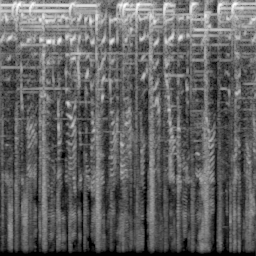

In [4]:
output = pipe()
display(output.images[0])
display(Audio(output.audios[0], rate=pipe.mel.get_sample_rate()))

音频的生成类似于无条件图像生成管线，使用一个2D UNet网络结构来生成音频的频谱，在后处理中被转换为最终的音频。

### 8.1.2 从音频到频谱的转换

tensor(5.5300e-14) tensor(1.0029)


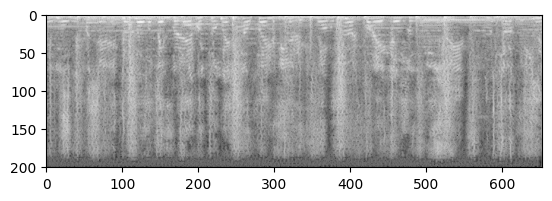

In [5]:
# 使用torchaudio模块计算并绘制所生成音频样本的频谱
spec_transform = AT.Spectrogram(power=2)
spectrogram = spec_transform(torch.tensor(output.audios[0]))
print(spectrogram.min(), spectrogram.max())
log_spectrogram = spectrogram.log()
plt.imshow(log_spectrogram[0], cmap='gray');

![torchaudio docs diagram](https://download.pytorch.org/torchaudio/tutorial-assets/torchaudio_feature_extractions.png)
_一些来自 [torchaudio docs](https://pytorch.org/audio/stable/transforms.html)的音频转换方法_

In [7]:
# 使用梅尔频谱进行转换，对不同频率成分进行变换，符合人耳感知特性。
a = pipe.mel.image_to_audio(output.images[0])
a.shape

(130560,)

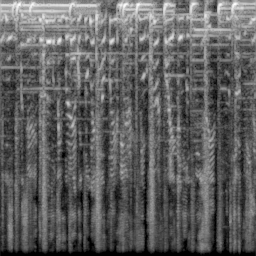

In [8]:
# 读取源音频数据
pipe.mel.load_audio(raw_audio=a)
# 将源音频数据转换为频谱图像
im = pipe.mel.audio_slice_to_image(0)
im

In [9]:
# 获取使用的采样率
sample_rate_pipeline = pipe.mel.get_sample_rate()

In [10]:
display(Audio(output.audios[0], rate=sample_rate_pipeline))

### 8.1.3 微调管线

In [18]:
from datasets import load_dataset

# 加载数据集
dataset = load_dataset('lewtun/music_genres', split='train')
dataset

Dataset({
    features: ['audio', 'song_id', 'genre_id', 'genre'],
    num_rows: 19909
})

In [19]:
for g in list(set(dataset['genre'])):
    print(g, sum(x==g for x in dataset['genre']))

Ambient Electronic 796
Punk 2582
Soul-RnB 94
Easy Listening 13
Experimental 1800
Country 142
Instrumental 1044
Rock 3095
Folk 1214
Blues 58
Hip-Hop 1757
Classical 495
Chiptune / Glitch 1181
Old-Time / Historic 408
Pop 945
Jazz 306
Spoken 94
International 814
Electronic 3071


In [21]:
sample_rate_dataset = dataset[0]['audio']['sampling_rate']

In [22]:
resampler = AT.Resample(sample_rate_dataset, sample_rate_pipeline, dtype=torch.float32)
to_t = IT.ToTensor()

def to_image(audio_array):
    audio_tensor = torch.tensor(audio_array).to(torch.float32)
    audio_tensor = resampler(audio_tensor)
    # 加载音频
    pipe.mel.load_audio(raw_audio=np.array(audio_tensor))
    num_slices = pipe.mel.get_number_of_slices()
    # 每次随机选取一张
    slice_idx = random.randint(0, num_slices-1)
    # 得到频谱图像
    im = pipe.mel.audio_slice_to_image(slice_idx) 
    return im

In [48]:
def collate_fn(examples):
    # 将图像转变为张量，再缩放到(-1, 1)区间，再变成数组
    audio_ims = [to_t(to_image(x['audio']['array']))*2-1 for x in examples]
    return torch.stack(audio_ims)

# 创建一个只包含Chiptune/Glitch风格的音乐
batch_size=4
# 设置训练风格
chosen_genre = 'Electronic'
indexes = [i for i, g in enumerate(dataset['genre']) if g == chosen_genre]
filtered_dataset = dataset.select(indexes)
filtered_dataset = filtered_dataset.select(range(100))
dl = torch.utils.data.DataLoader(filtered_dataset.shuffle(), batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
batch = next(iter(dl))
print(batch.shape)

torch.Size([4, 1, 256, 256])


### 8.1.4 训练循环

In [60]:
epochs = 3
lr = 1e-4

pipe.unet.train()
pipe.scheduler.set_timesteps(1000)
optimizer = torch.optim.AdamW(pipe.unet.parameters(), lr=lr)

for epoch in range(epochs):
    for step, batch in tqdm(enumerate(dl), total=len(dl)):
        # 输入图片
        clean_images = batch.to(device)
        bs = clean_images.shape[0]
        # 为每一张图片设置一个随机的时间步
        timesteps = torch.randint(
            0, pipe.scheduler.config.num_train_timesteps, (bs,), device=clean_images.device
        ).long()
        
        # 添加噪声
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        noisy_images = pipe.scheduler.add_noise(clean_images, noise, timesteps)
        
        # 得到噪声预测
        noise_pred = pipe.unet(noisy_images, timesteps, return_dict=False)[0]
        
        # 计算损失
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)
        
        # 更新模型参数
        optimizer.step()
        optimizer.zero_grad()

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

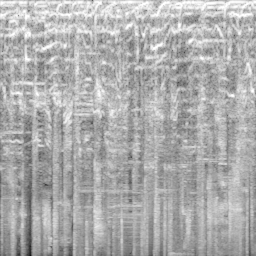

In [61]:
output = pipe()
display(output.images[0])
display(Audio(output.audios[0], rate=22050))

  0%|          | 0/1000 [00:00<?, ?it/s]

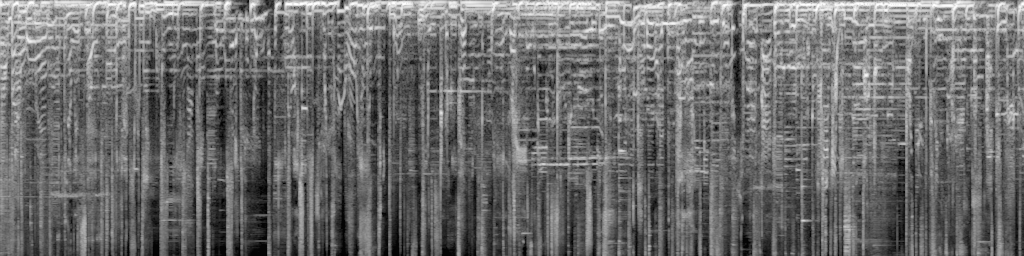

In [67]:
# 输入一个不同形状的起点噪声张量，可以得到一个更长的频谱样本
noise = torch.randn(1, 1, pipe.unet.sample_size, pipe.unet.sample_size*4).to(device)
output = pipe(noise=noise)
display(output.images[0])
display(Audio(output.audios[0], rate=22050))